In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML
from matplotlib import rcParams
import seaborn as sns
from textwrap import wrap
from tqdm import tqdm
import pandas as pd
import re
%matplotlib widget

In [ ]:
def read_tensors(dir, prompt=None, tensor_names=None):
    tensors = {}
    
    prompts = [ x for x in os.listdir(dir) if x == prompt ] if prompt is not None else [ x for x in os.listdir(dir) if os.path.isdir(os.path.join(dir, x)) ]
    for prompt in prompts:
        tensors[prompt] = {}       
        for timestep in tqdm(os.listdir(os.path.join(dir, prompt)), desc=f"Loading tensors for prompt {prompt}"):
            t = int(timestep.split('_')[1])  # Extract the timestep from the folder name
            tensors[prompt][t] = {}
            if tensor_names is not None:
                # Filter tensors based on the provided names
                tensor_objs = [tensor_obj for tensor_obj in os.listdir(os.path.join(dir, prompt, timestep)) if tensor_obj[:-3] in tensor_names]
            else:
                tensor_objs = os.listdir(os.path.join(dir, prompt, timestep))
            for tensor_obj in tensor_objs:
                if tensor_obj.endswith('.pt'):
                    key = tensor_obj[:-3]
                    # print(f"Loading tensor {key} for prompt {prompt}, timestep {t}")
                    tensors[prompt][t][key] = torch.load(os.path.join(dir, prompt, timestep, tensor_obj), map_location='cpu')
    return tensors

In [2]:
def normalize_tensor(tensor):
    """
    Normalize a tensor to the range [0, 1].
    tensor: [f, h, w]
    """
    min_val = tensor.min()
    max_val = tensor.max()
    if max_val - min_val == 0:
        return tensor
    t = (tensor - min_val) / (max_val - min_val)
    # change type to float32 for better visualization
    return t.float()

def animate_tensor(tensor, title, save_mp4_filename=None, fps=2):
    """
    tensor: [f, h, w]
    title: title of the animation
    save_mp4_filename: if provided, saves the animation as an mp4 file with this name
    fps: frames per second for the animation
    """
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    fig.tight_layout()

    ax.set_title(title, fontsize=20)
    im = ax.imshow(normalize_tensor(tensor[0,:,:]), animated=True, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

    def updatefig(i):
        ax.set_title(title, fontsize=20)
        t = normalize_tensor(tensor[i, :, :])
        im.set_array(t)
        return im,

    ani = animation.FuncAnimation(fig, updatefig, frames=tensor.shape[0], interval=50, blit=True)
    if save_mp4_filename:
        print(f'Saving tensor_visualizations/{save_mp4_filename}.mp4')
        ani.save(f'tensor_visualizations/{save_mp4_filename}.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])
           
    return ani

In [4]:
grid_size = [21, 30, 52] # [F, H, W] 

In [ ]:
dir = 'tensors/'
prompt = "additpaper_t2v-1.3B_832*480_1_1_A_small_dog_playing_with_a_red_20250706_125328_ADDIT_A_white_kitten_playing_with_a_"
# '20250709_105847_attn_head_4_subject_mask_t2v-1.3B_832*480_1_1_Athletic_man_doing_gymnastics__edit_A_cat.'
tensors = read_tensors(dir, prompt, ['q1', 'k_context1', 'subject_mask'])

In [73]:
q1 = tensors[prompt][49]['q1'][0].permute(1, 0, 2)  # [num_heads, num_tokens, head_dim]
# k1 = tensors[prompt][49]['k1'][0].permute(1, 0, 2)  # [num_heads, num_tokens, head_dim]
# v1 = tensors[prompt][49]['v1'][0].permute(1, 0, 2)  # [num_heads, num_tokens, head_dim]
k_context1 = tensors[prompt][49]['k_context1'][0].permute(1, 0, 2)  # [num_heads, num_tokens, head_dim]
# v_context1 = tensors[prompt][49]['v_context1'][0].permute(1, 0, 2)  # [num_heads, num_tokens, head_dim]
# subject_mask = tensors[prompt][49]['subject_mask'][0].permute(1, 0, 2)  # [num_heads, num_tokens, head_dim]

In [67]:
q1.shape, k_context1.shape, subject_mask.shape


(torch.Size([12, 32760, 128]),
 torch.Size([12, 512, 128]),
 torch.Size([1, 32760, 1]))

In [74]:
# Compute attention map as q1 @ k_context1.permute(0, 2, 1) 
attention_map = q1 @ k_context1.permute(0, 2, 1)  # [num_heads, num_tokens, num_tokens]
attention_map = attention_map / (k_context1.shape[-1] ** 0.5)
# Normalize the attention map
attention_map = F.softmax(attention_map, dim=-1)

In [49]:
attention_map.shape

torch.Size([12, 32760, 512])

In [75]:
token_dict = {
    'dog': 1,
    'ball': 7,
    # 'playing': 3,
}
attention_maps = {
    k: attention_map[:,:,v].view(attention_map.shape[0], grid_size[0], grid_size[1], grid_size[2]) 
    for k, v in token_dict.items()
}

Saving tensor_visualizations/attention_map_dog_head0.mp4
Saving tensor_visualizations/attention_map_dog_head1.mp4
Saving tensor_visualizations/attention_map_dog_head2.mp4
Saving tensor_visualizations/attention_map_dog_head3.mp4
Saving tensor_visualizations/attention_map_dog_head4.mp4
Saving tensor_visualizations/attention_map_dog_head5.mp4
Saving tensor_visualizations/attention_map_dog_head6.mp4
Saving tensor_visualizations/attention_map_dog_head7.mp4
Saving tensor_visualizations/attention_map_dog_head8.mp4
Saving tensor_visualizations/attention_map_dog_head9.mp4
Saving tensor_visualizations/attention_map_dog_head10.mp4
Saving tensor_visualizations/attention_map_dog_head11.mp4
Saving tensor_visualizations/attention_map_ball_head0.mp4
Saving tensor_visualizations/attention_map_ball_head1.mp4
Saving tensor_visualizations/attention_map_ball_head2.mp4
Saving tensor_visualizations/attention_map_ball_head3.mp4
Saving tensor_visualizations/attention_map_ball_head4.mp4
Saving tensor_visualizat

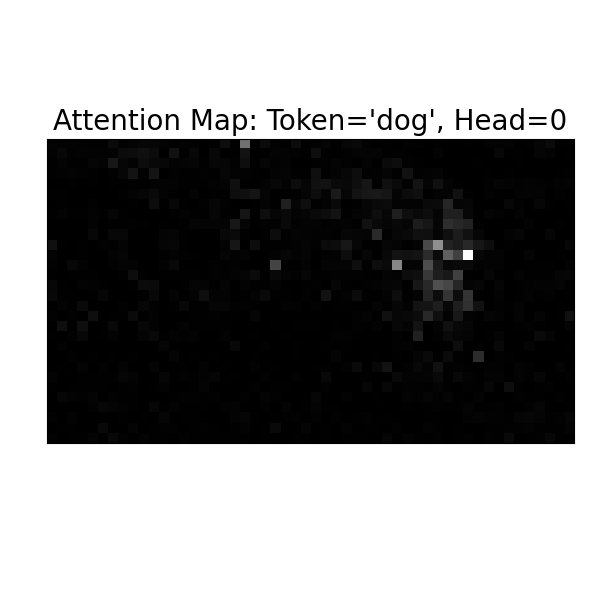

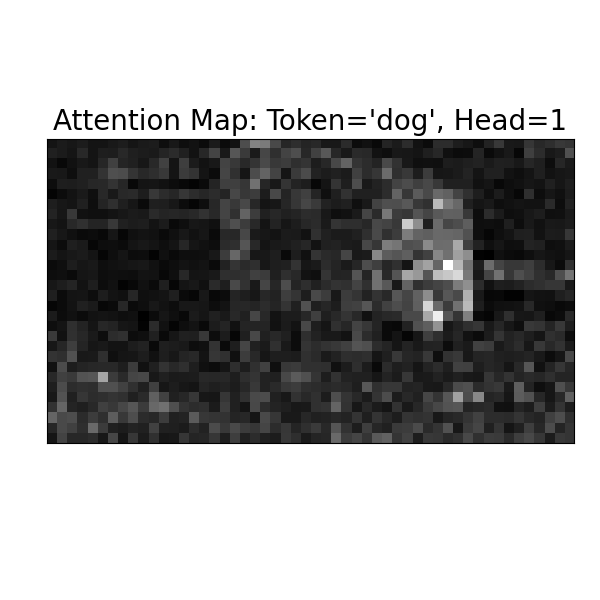

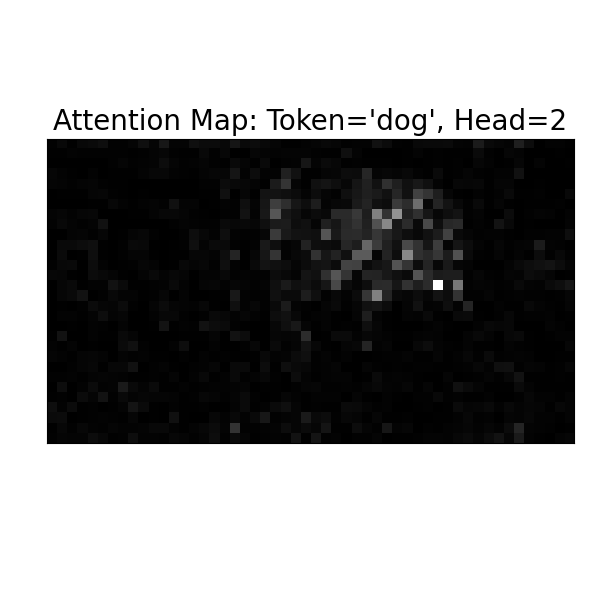

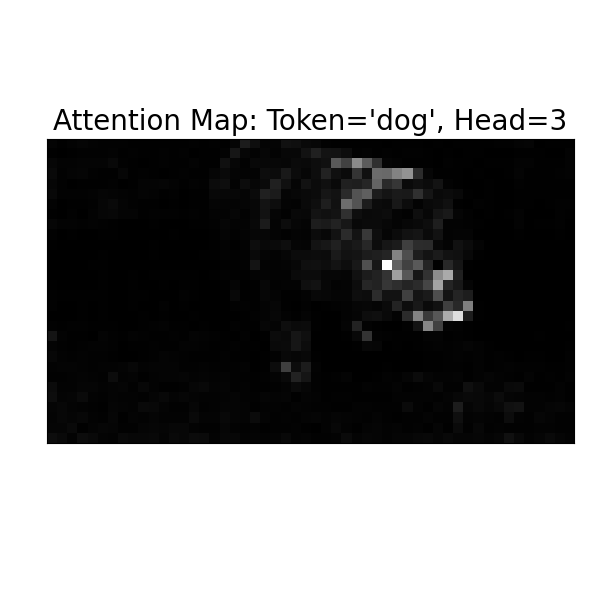

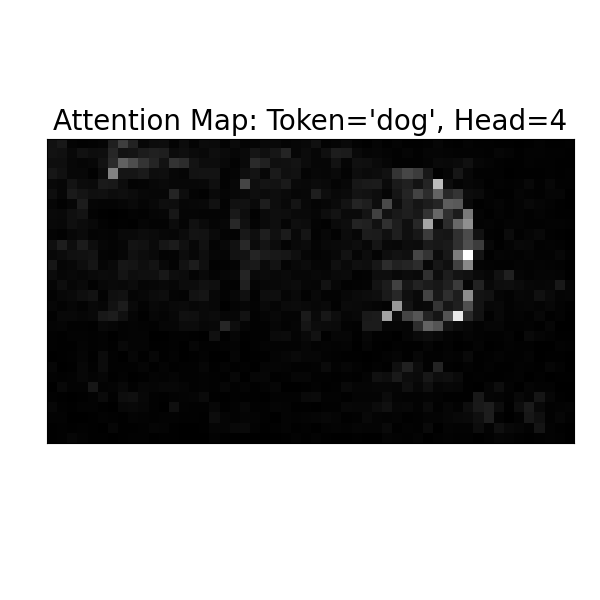

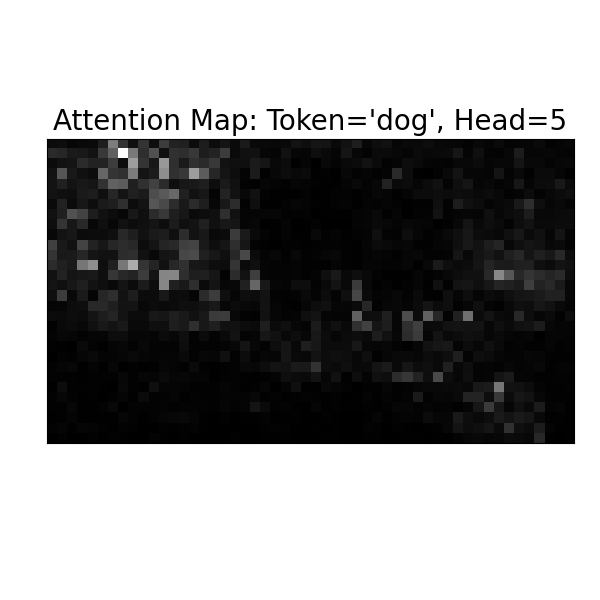

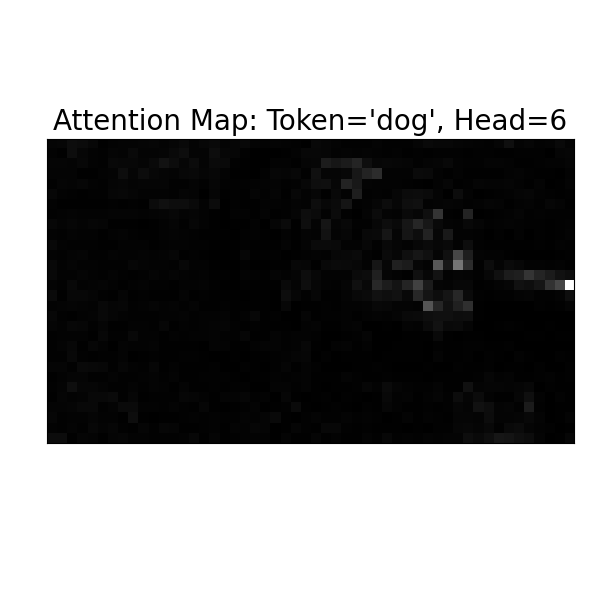

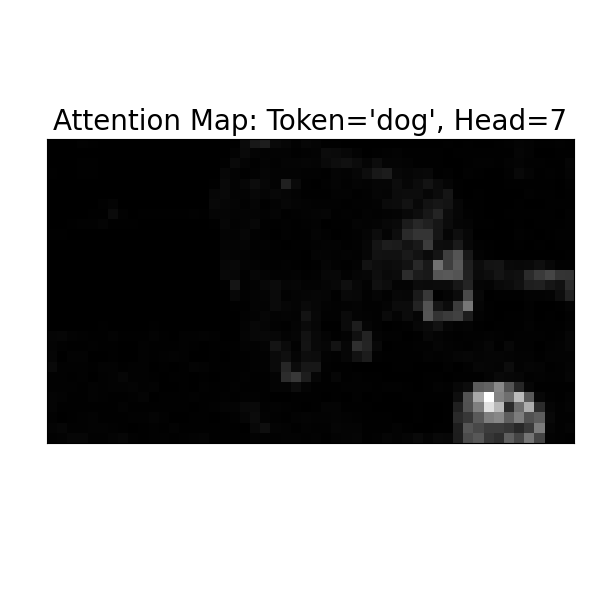

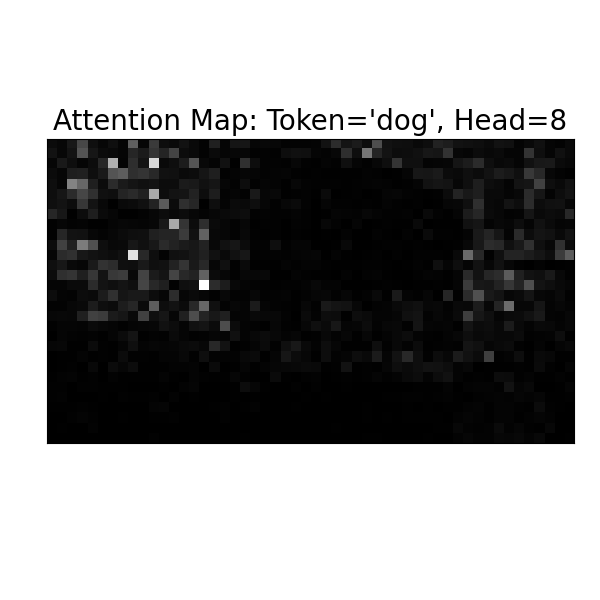

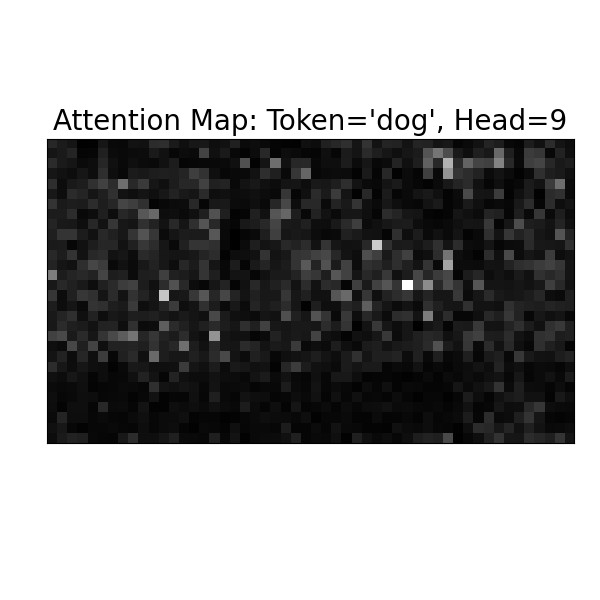

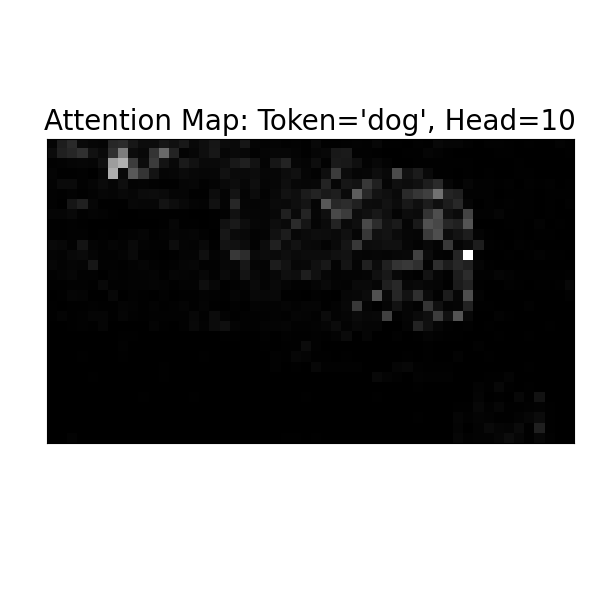

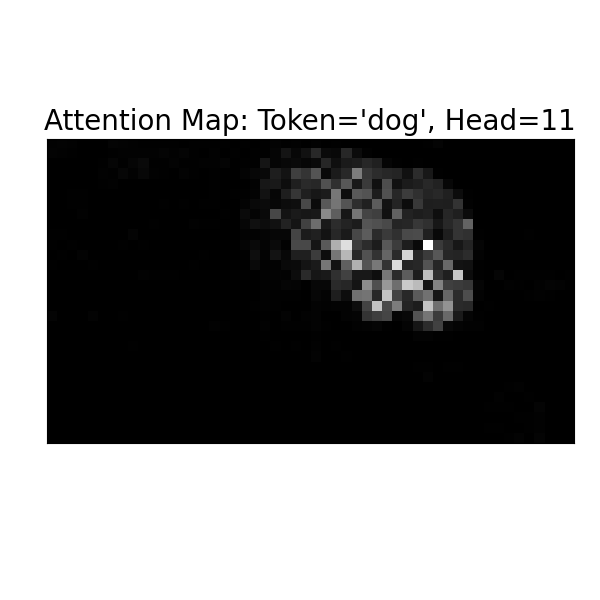

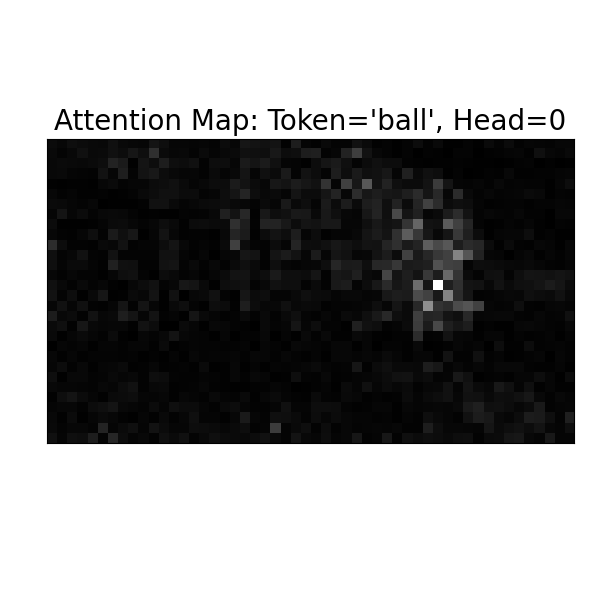

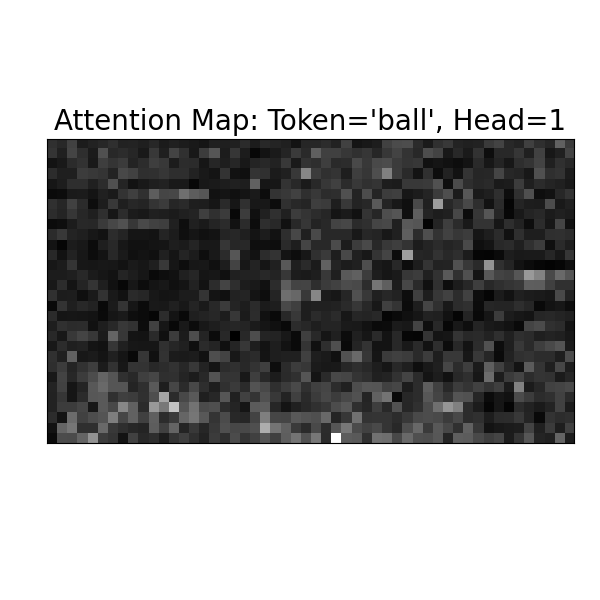

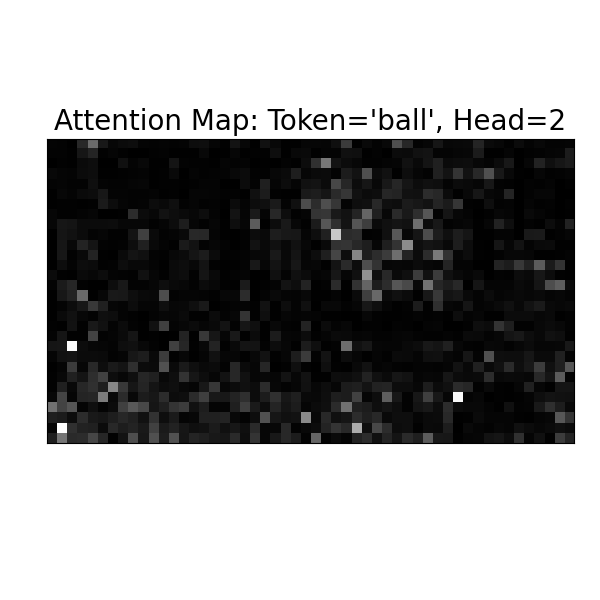

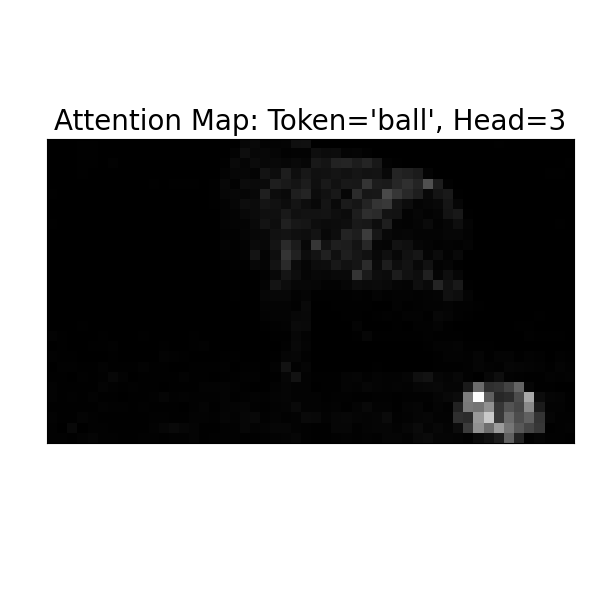

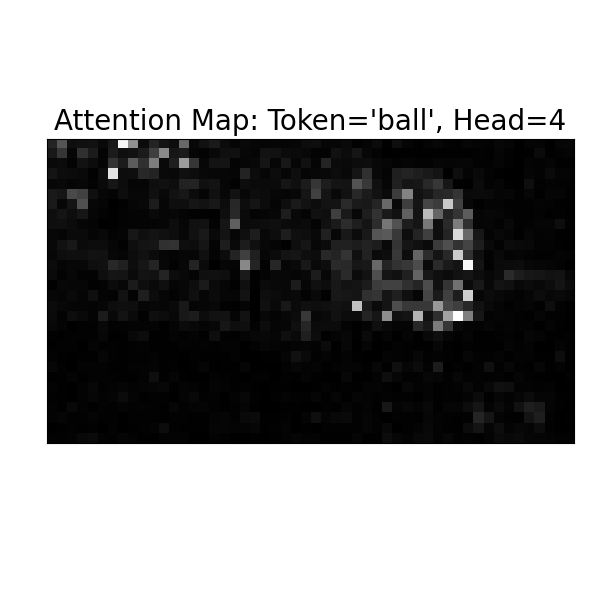

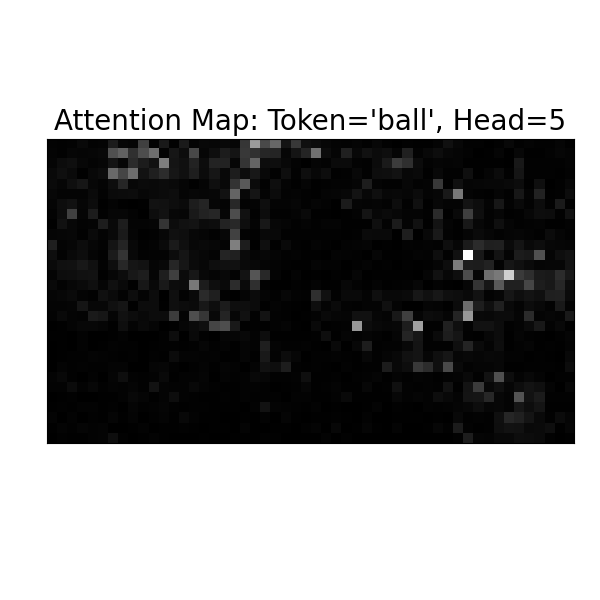

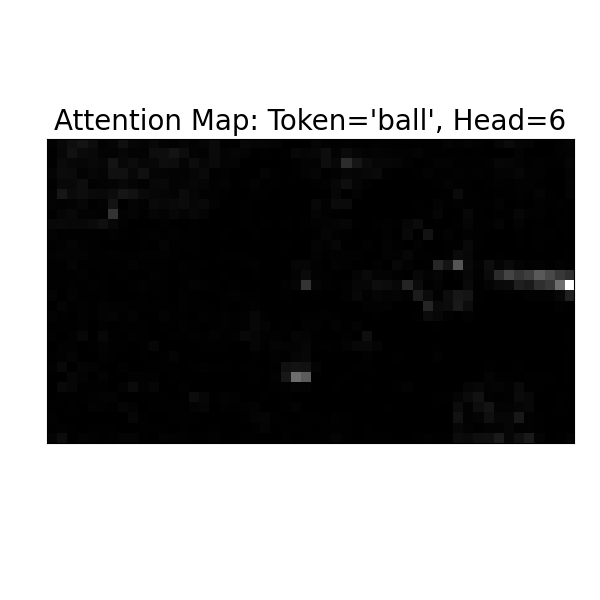

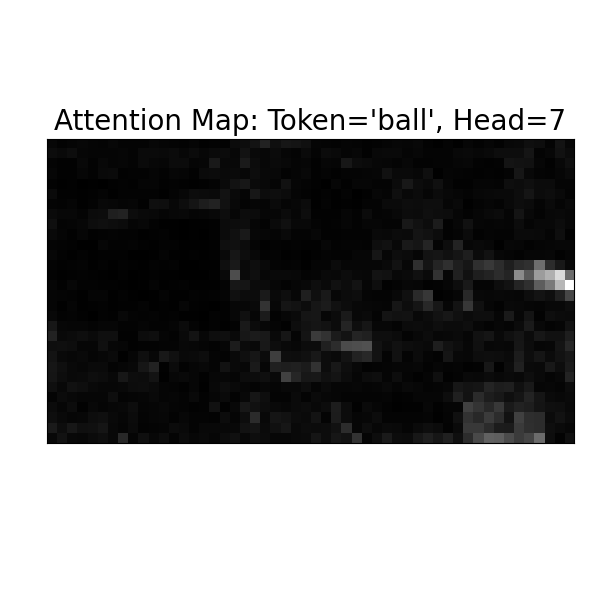

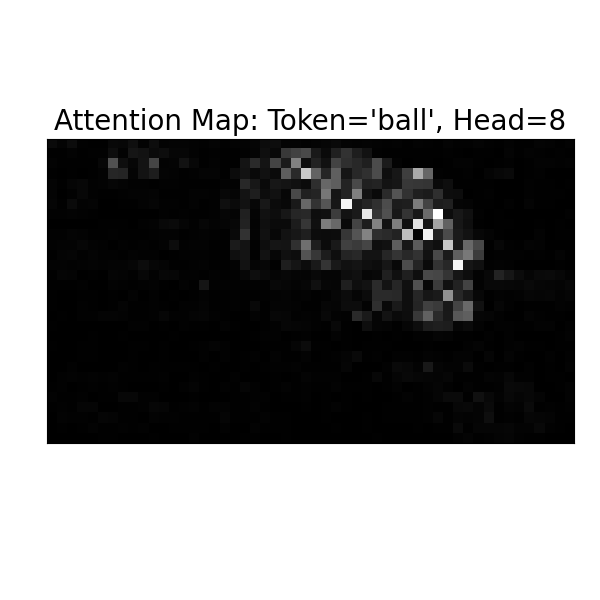

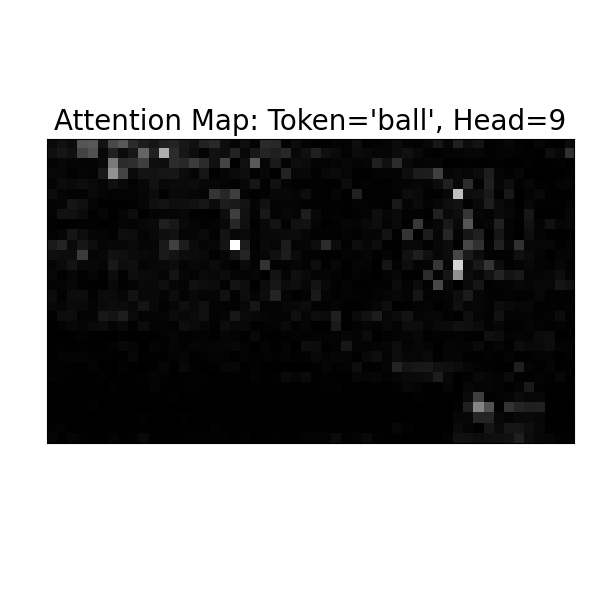

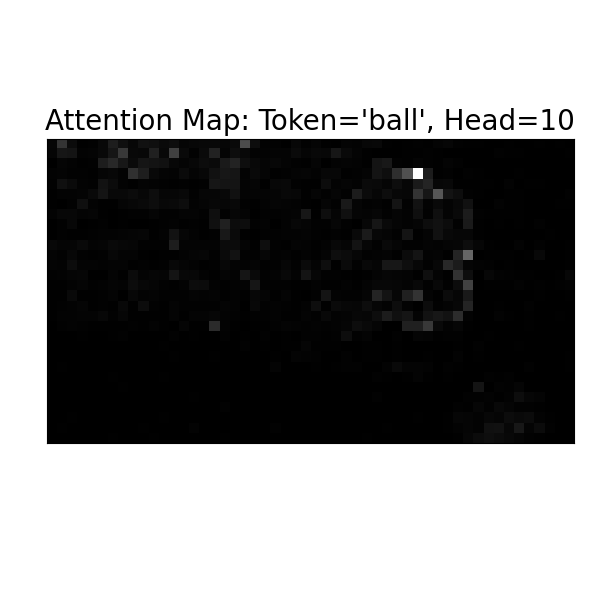

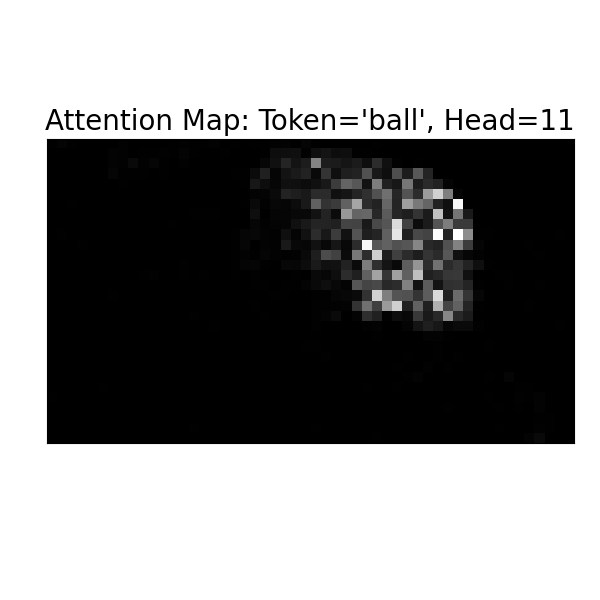

In [76]:
for k, attention_map in attention_maps.items():
    for i in range(attention_map.shape[0]):
        animate_tensor(attention_map[i], title=f"Attention Map: Token='{k}', Head={i}", save_mp4_filename=f"attention_map_{k}_head{i}", fps=3)

Saving tensor_visualizations/q1[h=0][c=0].mp4
Saving tensor_visualizations/k1[h=0][c=0].mp4
Saving tensor_visualizations/v1[h=0][c=0].mp4


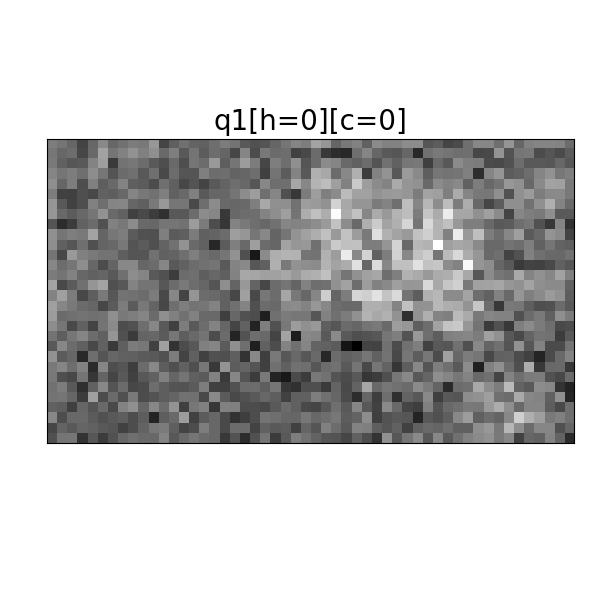

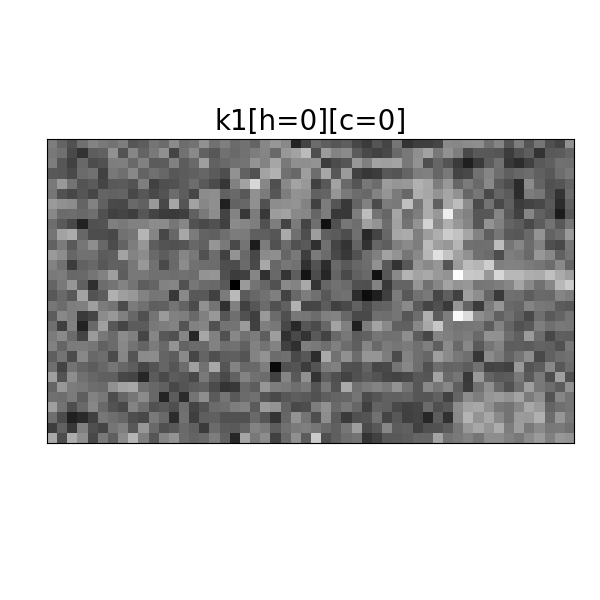

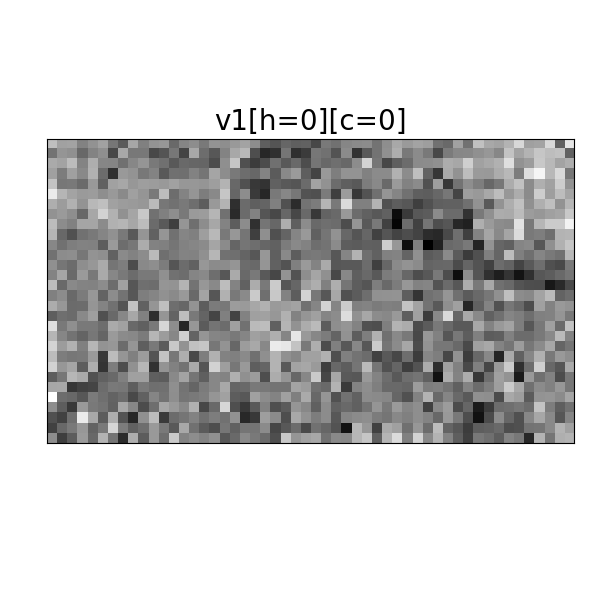

In [36]:
head = 0
channel = 0
animate_tensor(q1[0,:,:,:,head,channel], title=f"q1[h={head}][c={channel}]", save_mp4_filename=f'q1[h={head}][c={channel}]', fps=3)
animate_tensor(k1[0,:,:,:,head,channel], title=f"k1[h={head}][c={channel}]", save_mp4_filename=f'k1[h={head}][c={channel}]', fps=3)
animate_tensor(v1[0,:,:,:,head,channel], title=f"v1[h={head}][c={channel}]", save_mp4_filename=f'v1[h={head}][c={channel}]', fps=3)

In [ ]:
for k in tensors[prompt][49].keys():
    print(f"{k}: {tensors[prompt][49][k].shape}")
    # animate_tensor(tensors[prompt][49]['x0_pred1'][0], title=f"t2v-1.3B_832*480_1_1_A_small_dog_playing_with_a_red_20250706_125328_edit_A_white_kitten_playing_with_a_", save_mp4_filename='x0_pred1', fps=5)
    # animate_tensor(tensors[prompt][49][k], title=f"{k}", save_mp4_filename='{k}', fps=3)

x0_pred1: torch.Size([16, 21, 60, 104])
k1: torch.Size([1, 32760, 12, 128])
q1: torch.Size([1, 32760, 12, 128])
v1: torch.Size([1, 32760, 12, 128])


In [5]:
# first frame of q1 at timestep 49
q_frame = tensors[prompt][49]['q1'][0, :, :, :].squeeze(0).permute(1, 0, 2) # [num_heads, F*H*W, head_dim]
k_frame = tensors[prompt][49]['k_context1'][0, :, :, :].squeeze(0).permute(1, 0, 2) # [num_heads, L, head_dim]

In [6]:
qk = q_frame @ k_frame.transpose(-2, -1)  # [num_heads, F*H*W, L]

In [7]:
softmax_qk = F.softmax(qk, dim=-1)  # [num_heads, F*H*W, L]

In [8]:
# average over heads
avg_softmax_qk = softmax_qk.mean(dim=0)  # [F*H*W, L]

In [9]:
# reshape to [F, H, W, L]
avg_softmax_qk = avg_softmax_qk.reshape(grid_size[0], grid_size[1], grid_size[2], -1)  # [F, H, W, L]

In [57]:
# take channels = [0, ..., 15] (4^2) and create a tensor of shape [F, 4*H, 4*W] where each 4x4 block corresponds to a channel
def create_heatmap_tensor(avg_softmax_qk, channels):
    num_channels = len(channels)
    sqrt_num_channels = int(num_channels**0.5)
    assert float(sqrt_num_channels) == num_channels ** 0.5, "Number of channels must be a perfect square"

    f, w, h = avg_softmax_qk.shape[0], avg_softmax_qk.shape[1], avg_softmax_qk.shape[2]
    heatmap_tensor = torch.zeros((f, w * sqrt_num_channels, h * sqrt_num_channels))
    for i in range(sqrt_num_channels):
        for j in range(sqrt_num_channels):
            heatmap_tensor[:, i * w:(i + 1) * w, j * h:(j + 1) * h] = avg_softmax_qk[:, :, :, channels[i * sqrt_num_channels + j]]

    return heatmap_tensor

In [58]:
first_4_channels = create_heatmap_tensor(avg_softmax_qk, list(range(4)))

In [60]:
first_4_channels = first_4_channels.unsqueeze(-1)

In [61]:
ani = animate_tensor(avg_softmax_qk[:,:,:,0], 'Average Softmax QK')

<IPython.core.display.Javascript object>

In [62]:
HTML(ani.to_jshtml())

In [ ]:
def animate_channels(tensor, channels=None, title="", save_mp4_filename=None, fps=2):
    """
    tensor: [f, h, w, c]
    title: title of the animation
    save_mp4_filename: if provided, saves the animation as an mp4 file with this name
    fps: frames per second for the animation
    """
    f, h, w, c = tensor.shape
    # create a figure with c subplots in a grid
    channels = channels if channels is not None else list(range(c))
    grid_len = int(len(channels)**0.5)
    assert float(grid_len) == len(channels) ** 0.5, "Number of channels must be a perfect square"
    fig, axs = plt.subplots(grid_len, grid_len, figsize=(10, 10), dpi=900)
    fig.tight_layout()

    fig.suptitle(title, fontsize=20)
    ims = [None] * len(channels)

    for j, ax in enumerate(axs.flat):
        if j < len(channels):
            ax.set_title(f'Channel {channels[j]}', fontsize=20)
            ims[j] = ax.imshow(tensor[0,:,:,channels[j]], animated=True, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')

    def updatefig(i):
        for j, ax in enumerate(axs.flat):
            if j < len(channels):
                ax.set_title(title, fontsize=20)
                t = tensor[i, :, :, channels[j]]
                ims[j].set_array(t)
        return ims

    ani = animation.FuncAnimation(fig, updatefig, frames=tensor.shape[0], interval=50, blit=True)
    if save_mp4_filename:
        print(f'Saving tensor_visualizations/{save_mp4_filename}.mp4')
        ani.save(f'tensor_visualizations/{save_mp4_filename}.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])
           
    plt.show()
    return ani

In [8]:
# load tensor subject_mask from tensors
masks = torch.load('tensors/masks.pt', map_location='cpu')

In [9]:
masks.shape

torch.Size([27, 60, 104])

Saving tensor_visualizations/masks.mp4


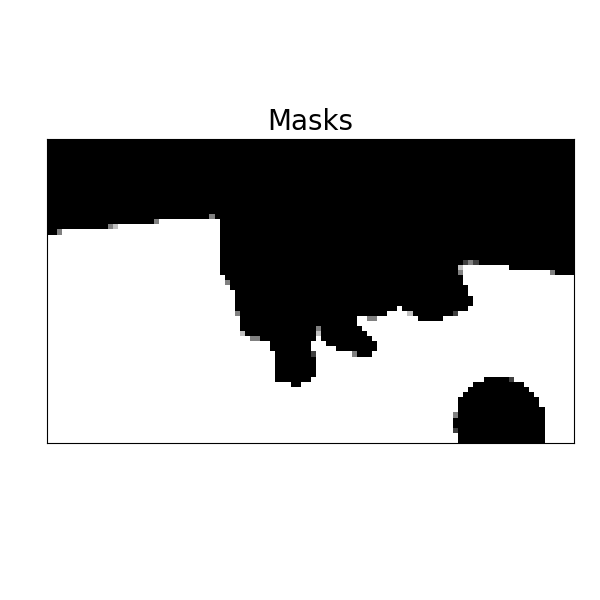

In [10]:
animate_tensor(masks, title="Masks", save_mp4_filename='masks', fps=3)